# Modelos para detectar contratos con adiciones - SECOP I
En este notebook se realiza la prueba de posibles modelos predictivos con los cuales se pretende detectar anomalías en la contratación pública de Bogotá. Se usa como insumo la base de datos SECOP_I_MASTER2.

Base con la cual se proceden a realizar modelos de clasificación binarios para 3 diferentes variables objetivo que determinan si el contrato tuvo alguna adición del respectivo tipo o no; `Marc Adiciones`,`Adicion en Valor` y `Adicion en Tiempo`. Adicionalmente, se realizan modelos con y sin incluir los modelos con prestacion de servicios.

1. **Modelos para Sancion (Marc Sancion)**
2. **Modelos para Adiciones**
    1. Balanceo de clases y selección doble de variables
    2. Pruebas Regresión logística y Bosques Aleatorios
    3. Comparación Modelos
    4. Repetición de  los puntos anteriores SIN prestación de servicios
    
- Buscar útilidad de AIC Y BIC para modelos de clasificación y su calculo.https://stackoverflow.com/questions/48185090/how-to-get-the-log-likelihood-for-a-logistic-regression-model-in-sklearn
- Probar elección de hiperparámetros con métrica fbeta.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import scipy.stats as stats
from scipy import stats
from scipy.stats import kruskal
from scipy import stats

import pycorrcat.pycorrcat as corrcat  #Calcula la V de cramer para variables categóricas.

import statsmodels.api as sm

import seaborn as sns
# os.chdir('C:/Users/santiago/Documents/Proyecto AI Veeduría')
os.chdir('C:/Users/juanc/OneDrive/Escritorio/LOCAL_Personal_Veeduria')


# Funciones auxiliares

In [2]:
# Gráficas
def corr_Matrix(data):
    '''
    Gráfica la matríz de correlación entre todas las variables 
    de la base de datos usada.
    '''
    f,ax = plt.subplots(figsize = (15,14))
    sns.heatmap(data.corr(),cmap = 'ocean_r', annot = True, cbar = False )
    ax.set_title('Correlation matrix')
    plt.show()


def plot_ROC(model, X_test, y_test, scaler, model_name='Model'):
    '''
    Gráfica la curva ROC y calcula el AUC para un modelo entrenado dados unos datos de prueba.
    Entradas:
            model: modelo sklearn entrenado del que se usa el método predict_proba()
            X_test: variables independientes de prueba.
            Y_test: variable dependiente de prueba.
            scaler: objeto preprocessing.StandardScaler() entrenado junto al modelo para escalar X_test.
            model_name: string con el nombre del modelo que se pasa para usar como leyenda de la curva ROC
    Salida:
            Gráfica curva ROC e impresión del AUC.
    '''
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(scaler.transform(X_test))
    lr_probs = lr_probs[:, 1]
    
    lr_auc = roc_auc_score(y_test, lr_probs)
    print("Model: ROC AUC = {:1.3f}".format(lr_auc))

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    plt.plot(ns_fpr, ns_tpr, linestyle = '--') 
    plt.plot(lr_fpr, lr_tpr, marker = '.', label = model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('ROC curve')
    plt.show()
    
    
def plot_CM(y_true, y_pred,norm=None):
    '''
    Tabla de matríz de confusión
    '''
    cm = confusion_matrix(y_true, y_pred,normalize=norm)
    cm_df = pd.DataFrame(cm, index = ['No','Sí'], columns = ['No','Sí'])
    cm_df.index.name = 'True'; cm_df.columns.name = 'Predicted'
    return cm_df

def balance(base, target):
    '''
    Función para balancear las bases de datos hacia el valor de la variables objetivo con menos observaciones.
    Entradas:
            base: base de pandas a balancear.
            target: nombre de la variable objetivo respecto a la que se balanceará.
    Salida:
            df_downsample: base balanceada.
    '''
    df_majority = base[base[target] == 0]
    df_minority = base[base[target] == 1]
    
    n = min(base[target].value_counts())
    df_majority_downsampled = resample(df_majority, replace = False, n_samples = n, random_state = 123)
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    
    return df_downsampled
def small_balanced_sample(X,y,N):
    """
    Muestrea un subconjunto de la base de datos con n dilas por categoria del target
    Entradas:
        X: matriz de datos 
        y: arreglo de ariable respuesta
        N: numero de muestras a muestrear para cada clase
        
    Salida:
        X_samp, y_samp: matriz de datos muestreada y variable output muestrado
    """
    # Concatenacion de X y output y en una sola tabla
    base = pd.concat([X,pd.DataFrame(y)],axis=1).dropna()    
    # Muestreo de N datos por columna
    base_new = base.groupby(y.name).sample(n=N,random_state=1)
    # Shuffle
    base_new = base_new.sample(frac=1).reset_index(drop=True)
    X_samp = base_new.iloc[:,:-1] # Todas las columnas excepto la ultima donde esta el target
    y_samp = base_new[y.name]
    return X_samp, y_samp

In [3]:
# Funciones para ejecutar modelos
def feature_selection(X, y,max_vars = None,umbral = None):
    '''
    Selección de variables estadísticamente significativas mediante random forest
    Entradas: X, y: Variables independietes y dependientes como base y serie de pandas respectivamente.
    Salida: X_varSelec: Pandas dataframe solo con las variables significativas.
    '''
    sel = SelectFromModel(RandomForestClassifier(n_estimators = 100),max_features = max_vars,threshold=umbral)
    sel.fit(X, y)
    
    variables_significativas = np.where(sel.get_support() == True)
    nombres_columnas = []
    for idx, i in enumerate(variables_significativas):
        nombres_columnas.append(X.columns[i])
    nombres_columnas = list(nombres_columnas[0])
    print("Variables estadísticamente significativas: \n{}".format(nombres_columnas))
    
    X_varSelec = sel.transform(X)
    X_varSelec = pd.DataFrame(X_varSelec, columns = nombres_columnas)
    
    return X_varSelec


def reg_log(X, y):
    '''
    Modelo de regresión logítica.
    Función para la realización de modelos mediante regresión logística. Imprime accuracy de la validación cruzada
    y datos de prueba , así como el recall en los datos de prueba.
    Entradas: 
            X: base de pandas con variables independientes.
            Y: serie de pandas con la variable objetivo.
    Salidas:
            rl: modelo de regresión logística entrenado.
            X_test, y_test: Datos de prueba.
            y_pred: valores de la variable respuesta estimados.
            scaler: objeto para escalar valores entrenado.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    rl = LogisticRegression(max_iter = 500)
    vc = cross_val_score(rl, scaler.transform(X_train), y_train, cv = 10, scoring = "accuracy")
    accuracy = vc.mean()
    print("Accuracy para Regresión Logística con validación cruzada: {:1.4f} ".format(accuracy) )
    
    rl = LogisticRegression(max_iter = 500)
    rl.fit(scaler.transform(X_train), y_train)

    y_pred = rl.predict(scaler.transform(X_test))
    print("El accuracy del test es: {:1.4f}".format( accuracy_score(y_test, y_pred) ))
    print("La sensitividad(recall) del test es: {:1.4f}".format( recall_score(y_test, y_pred) ))
    
    return rl, X_test, y_test, y_pred, scaler


def random_forest(X, y):
    '''
    Modelo random forest para clasificación.
    Entradas: 
            X: base de pandas con variables independientes.
            Y: serie de pandas con la variable objetivo.
    Salidas:
            arb: modelo de random forest entrenado.
            X_test, y_test: Datos de prueba.
            y_pred: valores de la variable respuesta estimados.
            scaler: objeto para escalar valores entrenado.    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    arb = RandomForestClassifier(random_state=42)
    arb.fit(scaler.transform(X_train), y_train)
    
    y_pred_arb = arb.predict(scaler.transform(X_test))
    print("Accuracy del test: {:1.4f}".format( accuracy_score(y_test, y_pred_arb) ))
    print("La sensitividad(recall) del test es: {:1.4f}".format( recall_score(y_test, y_pred_arb) ))

    return arb, X_test, y_test, y_pred_arb, scaler

In [4]:
# tarda un poco en leer los datos
df = pd.read_csv("SECOP_I_MASTER2.csv")
df = df.dropna()

In [5]:
# Columnas sobre adiciones
cols_ad = [n for n in df.columns if "Adicion" in n or "adicion" in n]
cols_ad

['Marc Adiciones',
 'Adicion en Valor',
 'Adicion en Tiempo',
 'Tiempo Adiciones (Dias)',
 'Valor Total de Adiciones',
 'Valor Contrato con Adiciones']

In [6]:
# Dimension y nombre de columnas
print("Dimension de los datos: ",df.shape)
df.columns

Dimension de los datos:  (603450, 49)


Index(['UID', 'Orden Entidad', 'Nombre de la Entidad', 'Código de la Entidad',
       'Tipo de Proceso', 'Estado del Proceso',
       'Causal de Otras Formas de Contratacion Directa',
       'Regimen de Contratacion', 'Objeto a Contratar', 'Tipo de Contrato',
       'cantidad de palabras objeto a contratar', 'Nombre Grupo',
       'Nombre Familia', 'Nombre Clase', 'EsPostConflicto', 'Def Origen Recur',
       'Num Origenes Recur', 'Descrip Origenes Recur', 'ID Ajudicacion',
       'Tipo Identifi del Contratista',
       'cantidad de palabras objeto del contrato a la Firma',
       'mismo detalle objeto a contratar despues de firma',
       'Identificacion del Contratista', 'Nom Raz Social Contratista',
       'Dpto y Muni Contratista', 'Fecha de Cargue en el SECOP',
       'Fecha de Firma del Contrato', 'Fecha Ini Ejec Contrato',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Fecha Ini Ejec - Fecha Firma Contrato', 'Mes Firma Contrato',
       'Dia del Mes Firma Contrato',

# Identificación de variables

In [7]:
#Variables a excluir al momento de entrenar modelos
vars_a_excluir = ["Orden Entidad","Estado del Proceso", "Nombre Familia",
                  "Nombre Clase","Nombre Sub Unidad Ejecutora","Moneda","Cuantia Proceso",
                  "Valor Contrato con Adiciones","Objeto a Contratar","Num Origenes Recur",
                 ]
# Variables que no son utiles para modelos
vars_a_excluir += ["UID","Nombre de la Entidad","Código de la Entidad","Descrip Origenes Recur",
                      "ID Ajudicacion","Tipo Identifi del Contratista","Identificacion del Contratista",
                     "Nom Raz Social Contratista","Fecha de Cargue en el SECOP","Fecha de Firma del Contrato",
                     "Fecha Ini Ejec Contrato","Fecha Ini Ejec Contrato","Fecha Fin Ejec Contrato"
                     ,'Ultima Actualizacion']
# vars_inluidas contiene los target
vars_incluidas = [name for name in df.columns if name not in vars_a_excluir]
# Marc Sancion como input es exluido
vars_categoricas = ["Tipo de Proceso","Causal de Otras Formas de Contratacion Directa","Regimen de Contratacion",
                    "Tipo de Contrato","Nombre Grupo","EsPostConflicto","Def Origen Recur",
                    "mismo detalle objeto a contratar despues de firma","Dpto y Muni Contratista","Mes Firma Contrato",
                   "Dia del Mes Firma Contrato","Dia de la Semana Firma Contrato","Marc Adiciones",]

### Dudas
- Las variables en formato fecha fueron incluidas como inputs en el modelo?
-  EsPostConflicto el desbalance es enorme, dejarla?
-  Diccionario de variables que quedaron en SECOP_1_MASTER2
- Departamento de Contratista hay unos pocos que vienen de municipios externos a Bogotá y Cundinamarca, dejarlos?
- Tiempo Adiciones (Dias) tiene datos negativos

In [8]:
print("Para Marc Adiciones:")
print(df["Marc Adiciones"].value_counts(),"\n \n")
print("Para Adicion en Valor:")
print(df["Adicion en Valor"].value_counts(),"\n \n")
print("Para Adicion en Tiempo:")
print(df["Adicion en Tiempo"].value_counts(),"\n \n")

Para Marc Adiciones:
0    451492
1    151958
Name: Marc Adiciones, dtype: int64 
 

Para Adicion en Valor:
0    461486
1    141964
Name: Adicion en Valor, dtype: int64 
 

Para Adicion en Tiempo:
0    460338
1    143112
Name: Adicion en Tiempo, dtype: int64 
 



Aunque el desbalance no es tan drástico como con `Marc Sancion` sí se mantiene un desbalance de 3 a 1 aproximadamente siendo la categroría 1 la menos presente para los 3 outputs. Por lo tanto, para cada output de adición se hará un downsampling de la clase 0 mientras que se mantiene intacta la cantidad de datos de la clase 1.

Primero se balanceará los datos para que tengan unos resultante se seleccionarán entre 10000 y 15000 datos de cada clase para ejecutar los modelos manteniendo el balance y que se ejecuten rápido los modelos.

# 1. Modelos con output `Marc Adiciones`
- Se exluye la informacion acerca de adiciones excepto el target 'Marc Adiciones'.
- **Se excluye la información acerca de sanciones, es decir 'Marc Sancion y Valor Sancion'**

In [9]:
# _MA: para Marc Adiciones
df_downsampled_MA = balance(df,"Marc Adiciones")
y_down_MA = df_downsampled_MA["Marc Adiciones"]
# Eliminamos las columnas innecesarias incluyendo la del target
X_down_MA = df_downsampled_MA.drop(columns = vars_a_excluir + ["Marc Adiciones","Adicion en Valor","Adicion en Tiempo",
                                                             "Marc Sancion","Valor Total de Adiciones"])
# Pasamos a dummies las columnas que sean categoricas
X_down_MA_dum = pd.get_dummies(data = X_down_MA, columns=list(set(vars_categoricas) - {"Marc Adiciones","Marc Sancion"}))

In [10]:
print("Variables iniciales para modelos:")
print(list(X_down_MA.columns))
print("Variables dummies iniciales")
# No esta quitando Valor Sancion :(
# Variables dummies
# print(list(X_down_MA_dum.columns))

Variables iniciales para modelos:
['Tipo de Proceso', 'Causal de Otras Formas de Contratacion Directa', 'Regimen de Contratacion', 'Tipo de Contrato', 'cantidad de palabras objeto a contratar', 'Nombre Grupo', 'EsPostConflicto', 'Def Origen Recur', 'cantidad de palabras objeto del contrato a la Firma', 'mismo detalle objeto a contratar despues de firma', 'Dpto y Muni Contratista', 'Fecha Firma Contrato - Fecha Cargue Secop', 'Fecha Ini Ejec - Fecha Firma Contrato', 'Mes Firma Contrato', 'Dia del Mes Firma Contrato', 'Dia de la Semana Firma Contrato', 'Plazo en dias de Ejec del Contrato', 'Tiempo Adiciones (Dias)', 'Cuantia Contrato', 'Valor Sancion', 'Ultima Actualizacion - Fecha Fin Ejec Contrato']
Variables dummies iniciales


## Seleccion de las variables mas importantes con Random Forest
Para seleccionar las variables utilizamos todos los datos después de balanceo.

In [11]:
print("Dimension de dataset con dummies: ",X_down_MA_dum.shape)

Dimension de dataset con dummies:  (303916, 209)


In [12]:
print("Columnas iniciales dummies")
np.array(X_down_MA_dum.columns)

Columnas iniciales dummies


array(['cantidad de palabras objeto a contratar',
       'cantidad de palabras objeto del contrato a la Firma',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Fecha Ini Ejec - Fecha Firma Contrato',
       'Plazo en dias de Ejec del Contrato', 'Tiempo Adiciones (Dias)',
       'Cuantia Contrato', 'Valor Sancion',
       'Ultima Actualizacion - Fecha Fin Ejec Contrato',
       'Dia de la Semana Firma Contrato_Domingo',
       'Dia de la Semana Firma Contrato_Jueves',
       'Dia de la Semana Firma Contrato_Lunes',
       'Dia de la Semana Firma Contrato_Martes',
       'Dia de la Semana Firma Contrato_Miércoles',
       'Dia de la Semana Firma Contrato_Sábado',
       'Dia de la Semana Firma Contrato_Viernes',
       'Causal de Otras Formas de Contratacion Directa_Arrendamiento o Adquisición de Inmuebles (Literal I)',
       'Causal de Otras Formas de Contratacion Directa_Contratación de Bienes y Servicios en el Sector Defensa y en el DAS (Literal D)',
       'Causal de Otr

## Eliminación de variables adicionales

In [13]:
# Quitamos Tiempo Adiciones (Dias)
X_down_MA_dum = X_down_MA_dum.drop(["Tiempo Adiciones (Dias)"],axis=1)

# Quitamos 'Ultima Actualizacion - Fecha Fin Ejec Contrato'
X_down_MA_dum = X_down_MA_dum.drop(['Ultima Actualizacion - Fecha Fin Ejec Contrato'],axis=1)

### Primera selección de variables
Se selecciona las variables más importantes con Random Forest sobre el dataset de dummies

In [14]:
X_down_MA_dum.shape[1]

207

In [15]:
# Tarda un poco
#num_vars, u = [10,-np.inf], # max_vars, umbral: parametros para controlar cantidad de variables
X_fselec = feature_selection(X_down_MA_dum, y_down_MA)

Variables estadísticamente significativas: 
['cantidad de palabras objeto a contratar', 'cantidad de palabras objeto del contrato a la Firma', 'Fecha Firma Contrato - Fecha Cargue Secop', 'Fecha Ini Ejec - Fecha Firma Contrato', 'Plazo en dias de Ejec del Contrato', 'Cuantia Contrato', 'Dia de la Semana Firma Contrato_Jueves', 'Dia de la Semana Firma Contrato_Lunes', 'Dia de la Semana Firma Contrato_Martes', 'Dia de la Semana Firma Contrato_Miércoles', 'Dia de la Semana Firma Contrato_Viernes', 'Dpto y Muni Contratista_Bogotá D.C.', 'Dpto y Muni Contratista_Cundinamarca', 'Mes Firma Contrato_Abril', 'Mes Firma Contrato_Agosto', 'Mes Firma Contrato_Diciembre', 'Mes Firma Contrato_Enero', 'Mes Firma Contrato_Febrero', 'Mes Firma Contrato_Julio', 'Mes Firma Contrato_Junio', 'Mes Firma Contrato_Marzo', 'Mes Firma Contrato_Mayo', 'Mes Firma Contrato_Noviembre', 'Mes Firma Contrato_Octubre', 'Mes Firma Contrato_Septiembre', 'Def Origen Recur_0', 'Def Origen Recur_1', 'mismo detalle objeto a 

In [16]:
X_fselec.shape

(303916, 37)

### Segunda selección de variables

In [17]:
# Tarda un poco
#num_vars, u = [10,-np.inf], # max_vars, umbral: parametros para controlar cantidad de variables
X_fselec_2 = feature_selection(X_fselec, y_down_MA)

Variables estadísticamente significativas: 
['cantidad de palabras objeto a contratar', 'cantidad de palabras objeto del contrato a la Firma', 'Fecha Firma Contrato - Fecha Cargue Secop', 'Fecha Ini Ejec - Fecha Firma Contrato', 'Plazo en dias de Ejec del Contrato', 'Cuantia Contrato']


**Nota:** La segunda selección de variables deja solo las numéricas.

In [18]:
X_fselec_2.shape

(303916, 6)

## Modelos con cantidad reducida de filas

In [19]:
print("Datos iniciales por clase")
print(y_down_MA.value_counts())
N = 15000 # 150000 por clase
X_MA, y_MA = small_balanced_sample(X_down_MA_dum,y_down_MA,N)
print("Nueva cantidad de datos por clase:")
print(y_MA.value_counts())
print("Dimension de matriz X: ",X_MA.shape)

Datos iniciales por clase
1    151958
0    151958
Name: Marc Adiciones, dtype: int64
Nueva cantidad de datos por clase:
1    15000
0    15000
Name: Marc Adiciones, dtype: int64
Dimension de matriz X:  (30000, 207)


## Graficas de variables numéricas

In [20]:
mat = pd.concat([X_MA,y_MA],axis=1).dropna()

In [22]:
#fig, axs = plt.subplots(3,2,figsize=(15,10))
#sns.boxplot(y="Marc Adiciones", x='cantidad de palabras objeto del contrato a la Firma', data=mat, orient="h", ax=axs[0,0])
#sns.boxplot(y="Marc Adiciones", x='Fecha Firma Contrato - Fecha Cargue Secop', data=mat, orient="h", ax=axs[0,1])

#sns.boxplot(y="Marc Adiciones", x='Fecha Ini Ejec - Fecha Firma Contrato', data=mat, orient="h", ax=axs[1,0])
#sns.boxplot(y="Marc Adiciones", x='Plazo en dias de Ejec del Contrato', data=mat, orient="h", ax=axs[1,1])

#sns.boxplot(y="Marc Adiciones", x='Cuantia Contrato', data=mat, orient="h", ax=axs[2,0])
#sns.boxplot(y="Marc Adiciones", x='Ultima Actualizacion - Fecha Fin Ejec Contrato', data=mat, orient="h", ax=axs[2,1])

## Regresion Logistica

### Con todas las variables

In [23]:
X_train_MA, X_test_MA, y_train_MA, y_test_MA = train_test_split(X_MA, y_MA, test_size=0.33, random_state=42)

In [24]:
# Escalador de datos
scaler = preprocessing.StandardScaler().fit(X_train_MA)
# Validacion cruzada
reglog = LogisticRegression(max_iter = 500)
vc = cross_val_score(reglog, scaler.transform(X_train_MA), y_train_MA, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Accuracy para Regresión Logística con validación cruzada: {:1.4f} ".format(accuracy) )

Accuracy para Regresión Logística con validación cruzada: 0.6291 


In [25]:
reglog = LogisticRegression(max_iter=500)
reglog.fit(scaler.transform(X_train_MA),y_train_MA)

LogisticRegression(max_iter=500)

In [26]:
y_pred = reglog.predict(scaler.transform(X_test_MA))
print("El accuracy del test es: {:1.4f}".format( accuracy_score(y_test_MA, y_pred) ))
print("La sensitividad(recall) del test es: {:1.4f}".format( recall_score(y_test_MA, y_pred) ))

El accuracy del test es: 0.6384
La sensitividad(recall) del test es: 0.6937


In [27]:
plot_CM(y_test_MA, y_pred,norm='true')

Predicted,No,Sí
True,,
No,0.583317,0.416683
Sí,0.306259,0.693741


Model: ROC AUC = 0.689


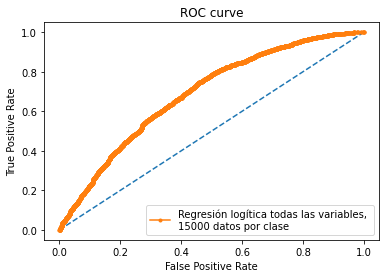

In [28]:
plot_ROC(reglog, X_test_MA, y_test_MA, scaler, model_name='Regresión logítica todas las variables, \n'+str(N)+" datos por clase")

### Con primera selección de variables

In [29]:
# Primero reducimos la cantidad de filas 
N = 15000 # 150000 por clase
X_fselec_MA, y_fselec_MA = small_balanced_sample(X_fselec,y_down_MA,N)

In [30]:
# Escalador de datos
scaler2 = preprocessing.StandardScaler().fit(X_fselec_MA)
# Validacion cruzada
reglog2 = LogisticRegression(max_iter = 500)
vc = cross_val_score(reglog2, scaler2.transform(X_fselec_MA), y_fselec_MA, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Accuracy para Regresión Logística con validación cruzada, 1era SELECCION DE VARIABLES: {:1.4f} ".format(accuracy) )

Accuracy para Regresión Logística con validación cruzada, 1era SELECCION DE VARIABLES: 0.4979 


In [31]:
regLog2, X_test2_MA, y_test2_MA, y_pred2_MA, scaler2_MA = reg_log(X_fselec_MA, y_fselec_MA)

Accuracy para Regresión Logística con validación cruzada: 0.4937 
El accuracy del test es: 0.5016
La sensitividad(recall) del test es: 0.4727


In [32]:
plot_CM(y_test2_MA, y_pred2_MA,norm='true')

Predicted,No,Sí
True,,
No,0.530444,0.469556
Sí,0.527333,0.472667


Model: ROC AUC = 0.499


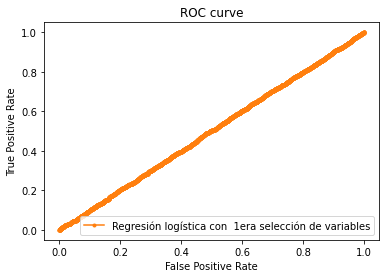

In [33]:
plot_ROC(regLog2, X_test2_MA, y_test2_MA, scaler2_MA, model_name='Regresión logística con  1era selección de variables')

### Conclusión
Para la regresión logística es mejor conservar todas las variables para que el accuracy sea de aproximadamente igual 70% de lo contrario la predicción es muy mala (accuracy de 50%, es decir, predicciones aleatorias).

## Bosques Aleatorios

### Con todas las variables

In [34]:
print(X_train_MA.shape, y_train_MA.shape)

(20100, 207) (20100,)


In [35]:
np.array(X_train_MA.columns)

array(['cantidad de palabras objeto a contratar',
       'cantidad de palabras objeto del contrato a la Firma',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Fecha Ini Ejec - Fecha Firma Contrato',
       'Plazo en dias de Ejec del Contrato', 'Cuantia Contrato',
       'Valor Sancion', 'Dia de la Semana Firma Contrato_Domingo',
       'Dia de la Semana Firma Contrato_Jueves',
       'Dia de la Semana Firma Contrato_Lunes',
       'Dia de la Semana Firma Contrato_Martes',
       'Dia de la Semana Firma Contrato_Miércoles',
       'Dia de la Semana Firma Contrato_Sábado',
       'Dia de la Semana Firma Contrato_Viernes',
       'Causal de Otras Formas de Contratacion Directa_Arrendamiento o Adquisición de Inmuebles (Literal I)',
       'Causal de Otras Formas de Contratacion Directa_Contratación de Bienes y Servicios en el Sector Defensa y en el DAS (Literal D)',
       'Causal de Otras Formas de Contratacion Directa_Contratación de Empréstitos (Literal B)',
       'Causal 

In [36]:
# Escalador de datos
scaler = preprocessing.StandardScaler().fit(X_train_MA)
# Validacion cruzada
arb = RandomForestClassifier(random_state=42)
vc = cross_val_score(arb, scaler.transform(X_train_MA), y_train_MA, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Accuracy para Bosque Aleatorio con validación cruzada: {:1.4f} ".format(accuracy) )

Accuracy para Bosque Aleatorio con validación cruzada: 0.7641 


In [37]:
vc

array([0.76268657, 0.76716418, 0.75472637, 0.76791045, 0.76791045])

In [38]:
X_MA.shape[1]

207

In [39]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_MA, y_MA)

Accuracy del test: 0.7716
La sensitividad(recall) del test es: 0.7864


In [40]:
plot_CM(y_test, y_pred_forest)

Predicted,No,Sí
True,,
No,3405,1095
Sí,961,3539


Model: ROC AUC = 0.862


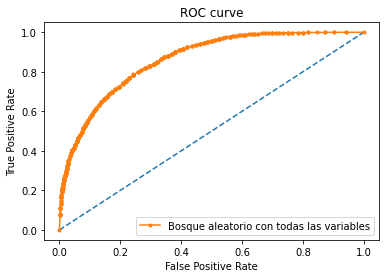

In [41]:
plot_ROC(forest, X_test, y_test, scaler, model_name='Bosque aleatorio con todas las variables')

### Con primera selección de variables

In [42]:
# Con X_fselec_MA, y_fselec_MA
N = 15000 # datos por clase
X_fselec_MA, y_fselec_MA = small_balanced_sample(X_fselec,y_down_MA,N)
# Resultados
forest_s1, X_test_s1, y_test_s1, y_pred_forest_s1, scaler_s1 = random_forest(X_fselec_MA, y_fselec_MA)

Accuracy del test: 0.4854
La sensitividad(recall) del test es: 0.4769


In [43]:
print(X_fselec_MA.shape)
print(np.array(X_fselec_MA.columns))

(30000, 37)
['cantidad de palabras objeto a contratar'
 'cantidad de palabras objeto del contrato a la Firma'
 'Fecha Firma Contrato - Fecha Cargue Secop'
 'Fecha Ini Ejec - Fecha Firma Contrato'
 'Plazo en dias de Ejec del Contrato' 'Cuantia Contrato'
 'Dia de la Semana Firma Contrato_Jueves'
 'Dia de la Semana Firma Contrato_Lunes'
 'Dia de la Semana Firma Contrato_Martes'
 'Dia de la Semana Firma Contrato_Miércoles'
 'Dia de la Semana Firma Contrato_Viernes'
 'Dpto y Muni Contratista_Bogotá D.C.'
 'Dpto y Muni Contratista_Cundinamarca' 'Mes Firma Contrato_Abril'
 'Mes Firma Contrato_Agosto' 'Mes Firma Contrato_Diciembre'
 'Mes Firma Contrato_Enero' 'Mes Firma Contrato_Febrero'
 'Mes Firma Contrato_Julio' 'Mes Firma Contrato_Junio'
 'Mes Firma Contrato_Marzo' 'Mes Firma Contrato_Mayo'
 'Mes Firma Contrato_Noviembre' 'Mes Firma Contrato_Octubre'
 'Mes Firma Contrato_Septiembre' 'Def Origen Recur_0' 'Def Origen Recur_1'
 'mismo detalle objeto a contratar despues de firma_0'
 'mismo det

In [44]:
plot_CM(y_test_s1, y_pred_forest_s1)

Predicted,No,Sí
True,,
No,2223,2277
Sí,2354,2146


Model: ROC AUC = 0.484


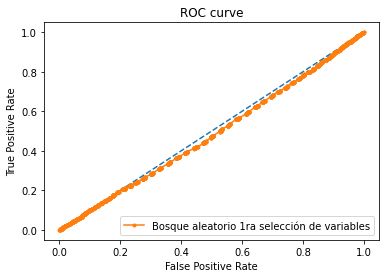

In [45]:
plot_ROC(forest_s1, X_test_s1, y_test_s1, scaler_s1, model_name='Bosque aleatorio 1ra selección de variables')

### Con segunda selección de variables

In [46]:
# Con X_fselec_MA, y_fselec_MA
N = 15000 # datos por clase
X_fselec_2_MA, y_fselec_2_MA = small_balanced_sample(X_fselec_2,y_down_MA,N)
# Resultados
forest_s2, X_test_s2, y_test_s2, y_pred_forest_s2, scaler_s2 = random_forest(X_fselec_2_MA, y_fselec_2_MA)

Accuracy del test: 0.4962
La sensitividad(recall) del test es: 0.4789


In [47]:
print(X_fselec_2_MA.shape)
print(np.array(X_fselec_2_MA.columns))

(30000, 6)
['cantidad de palabras objeto a contratar'
 'cantidad de palabras objeto del contrato a la Firma'
 'Fecha Firma Contrato - Fecha Cargue Secop'
 'Fecha Ini Ejec - Fecha Firma Contrato'
 'Plazo en dias de Ejec del Contrato' 'Cuantia Contrato']


In [48]:
plot_CM(y_test_s2, y_pred_forest_s2)

Predicted,No,Sí
True,,
No,2311,2189
Sí,2345,2155


Model: ROC AUC = 0.498


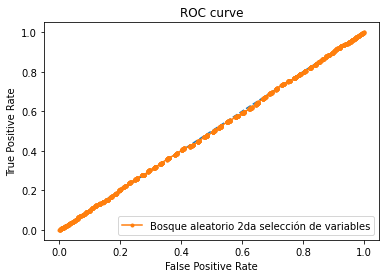

In [49]:
plot_ROC(forest_s2, X_test_s2, y_test_s2, scaler_s2, model_name='Bosque aleatorio 2da selección de variables')

### Con selección específica de variables
Se eliminaron grupos de variables de tal forma que se redujera considerablemente la cantidad de predictores para los modelos sin que disminuya mucho las métricas de rendimiento del modelo pasando de 209 predictores (contando dummies y continuas) a tan sólo 5: `cantidad de palabras objeto a contratar`, `Fecha Firma Contrato - Fecha Cargue Secop`, `Plazo en dias de Ejec del Contrato`, `Cuantia Contrato` y `mismo detalle objeto a contratar despues de firma_1`.

In [50]:
cols = ['cantidad de palabras objeto a contratar',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Plazo en dias de Ejec del Contrato',
       'Cuantia Contrato',
       'mismo detalle objeto a contratar despues de firma_1']

In [51]:
X_fselec_3_MA = X_down_MA_dum[cols]

In [52]:
X_fselec_3_MA.shape

(303916, 5)

In [53]:
X_s3_MA, y_s3_MA = small_balanced_sample(X_fselec_3_MA,y_down_MA,15000)

In [54]:
X_train_s3_MA, X_test_s3_MA, y_train_s3_MA, y_test_s3_MA = train_test_split(X_s3_MA, y_s3_MA,
                                                                            test_size=0.33, random_state=42)
# Escalador de datos
scaler_s3 = preprocessing.StandardScaler().fit(X_train_s3_MA)
# Validacion cruzada
arb = RandomForestClassifier(random_state=42)
vc = cross_val_score(arb, scaler_s3.transform(X_train_s3_MA), y_train_s3_MA, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Accuracy para Bosque Aleatorio con validación cruzada: {:1.4f} ".format(accuracy) )

Accuracy para Bosque Aleatorio con validación cruzada: 0.7346 


In [55]:
vc

array([0.72288557, 0.73208955, 0.74129353, 0.73631841, 0.74029851])

In [56]:
X_train_s3_MA.shape

(20100, 5)

In [57]:
# Con X_fselec_MA, y_fselec_MA
N = 15000 # datos por clase
X_fselec_3_MA, y_fselec_3_MA = small_balanced_sample(X_fselec_3_MA,y_down_MA,N)
# Resultados
forest_s3, X_test_s3, y_test_s3, y_pred_forest_s3, scaler_s3 = random_forest(X_fselec_3_MA, y_fselec_3_MA)

Accuracy del test: 0.7412
La sensitividad(recall) del test es: 0.7433


In [58]:
plot_CM(y_test_s3, y_pred_forest_s3)

Predicted,No,Sí
True,,
No,3326,1174
Sí,1155,3345


Model: ROC AUC = 0.831


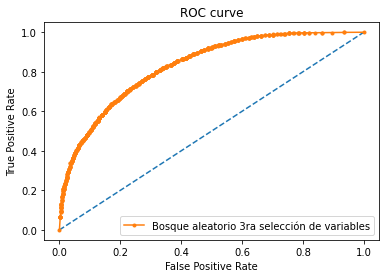

In [59]:
plot_ROC(forest_s3, X_test_s3, y_test_s3, scaler_s3, model_name='Bosque aleatorio 3ra selección de variables')

- Con 75 variables el cambio no es mucho: el accuracy promedio (CV) se mantiene alrededor de 0.76 al igual que con todas las variables. El ROC AUC score cambió de 0.859 a 0.861. Como es prácticamente lo mismo, se probará con unas 60 variables.
-  Con 58 variables: 0.75 accuracy promedio (CV) y ROC AUC Score = 0.84
- Quitar Mes Firma de contrato, dejar mismo detalle objeto a contratar
- Es Post Conflicto se puede quitar, no cambio mucho ni el accracy ni el ROC AUC score
- Causal de otras formas de contratacion tampoco funcionan
- Ni Tipo de Proceso ni Tipo de Contrato afectan el rendimiento del modelo
- Quitar Nombre Grupo Baja levemente  pero casi nada
- Con Def Origen bajó un poc los resultados (más que al quitar Nombre Grupo) pero no es grave

## Modelos sin prestaciones de servicios

In [60]:
df_downsampled_MA["Tipo de Contrato"].value_counts()

Prestación de Servicios    260216
Suministro                  16130
Otro Tipo de Contrato       10245
Compraventa                  6225
Obra                         5293
Arrendamiento                2837
Interventoría                1208
Consultoría                   934
Comodato                      666
Acuerdo Marco                  77
Concesión                      38
Fiducia                        24
Crédito                        15
Agregación de Demanda           4
No definido                     4
Name: Tipo de Contrato, dtype: int64

In [103]:
df_downsampled_MA.columns

Index(['UID', 'Orden Entidad', 'Nombre de la Entidad', 'Código de la Entidad',
       'Tipo de Proceso', 'Estado del Proceso',
       'Causal de Otras Formas de Contratacion Directa',
       'Regimen de Contratacion', 'Objeto a Contratar', 'Tipo de Contrato',
       'cantidad de palabras objeto a contratar', 'Nombre Grupo',
       'Nombre Familia', 'Nombre Clase', 'EsPostConflicto', 'Def Origen Recur',
       'Num Origenes Recur', 'Descrip Origenes Recur', 'ID Ajudicacion',
       'Tipo Identifi del Contratista',
       'cantidad de palabras objeto del contrato a la Firma',
       'mismo detalle objeto a contratar despues de firma',
       'Identificacion del Contratista', 'Nom Raz Social Contratista',
       'Dpto y Muni Contratista', 'Fecha de Cargue en el SECOP',
       'Fecha de Firma del Contrato', 'Fecha Ini Ejec Contrato',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Fecha Ini Ejec - Fecha Firma Contrato', 'Mes Firma Contrato',
       'Dia del Mes Firma Contrato',

In [130]:
X_noprestacion = df_downsampled_MA[df_downsampled_MA["Tipo de Contrato"] != "Prestación de Servicios"]
y_noprestacion = X_noprestacion["Marc Adiciones"]

X_noprestacion = X_noprestacion.drop(columns = vars_a_excluir + ["Marc Adiciones","Adicion en Valor","Adicion en Tiempo",
                                                                 "Marc Sancion","Valor Total de Adiciones"])

vars_categoricas = ['Tipo de Proceso', 'Causal de Otras Formas de Contratacion Directa',
                    'Regimen de Contratacion', 'Tipo de Contrato','Nombre Grupo',"Dpto y Muni Contratista",
                    'EsPostConflicto', 'Def Origen Recur',"mismo detalle objeto a contratar despues de firma",
                    "Mes Firma Contrato","Dia del Mes Firma Contrato","Dia de la Semana Firma Contrato"]
X_noprestacion_dum = pd.get_dummies(data = X_noprestacion, columns = vars_categoricas)
X_noprestacion_dum = X_noprestacion_dum.drop(columns=['Ultima Actualizacion - Fecha Fin Ejec Contrato','Tiempo Adiciones (Dias)'])

In [131]:
X_noprestacion_dum.columns

Index(['cantidad de palabras objeto a contratar',
       'cantidad de palabras objeto del contrato a la Firma',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Fecha Ini Ejec - Fecha Firma Contrato',
       'Plazo en dias de Ejec del Contrato', 'Cuantia Contrato',
       'Valor Sancion', 'Tipo de Proceso_Asociación Público Privada',
       'Tipo de Proceso_Concurso de Méritos Abierto',
       'Tipo de Proceso_Concurso de Méritos con Lista Corta',
       ...
       'Dia del Mes Firma Contrato_29', 'Dia del Mes Firma Contrato_30',
       'Dia del Mes Firma Contrato_31',
       'Dia de la Semana Firma Contrato_Domingo',
       'Dia de la Semana Firma Contrato_Jueves',
       'Dia de la Semana Firma Contrato_Lunes',
       'Dia de la Semana Firma Contrato_Martes',
       'Dia de la Semana Firma Contrato_Miércoles',
       'Dia de la Semana Firma Contrato_Sábado',
       'Dia de la Semana Firma Contrato_Viernes'],
      dtype='object', length=172)

In [132]:
print("Cantidad de datos sin prestacion de servicios: ",len(X_noprestacion))
y_noprestacion.value_counts()

Cantidad de datos sin prestacion de servicios:  43700


0    28116
1    15584
Name: Marc Adiciones, dtype: int64

## Regresión logística

### Con todas las variables

In [133]:
regLog_noserv, X_test_noserv, y_test_noserv, y_pred_noserv, scaler_noserv = reg_log(X_noprestacion_dum, y_noprestacion)

Accuracy para Regresión Logística con validación cruzada: 0.7280 
El accuracy del test es: 0.7236
La sensitividad(recall) del test es: 0.5044


In [134]:
plot_CM(y_test_noserv, y_pred_noserv)

Predicted,No,Sí
True,,
No,7129,1306
Sí,2317,2358


Model: ROC AUC = 0.800


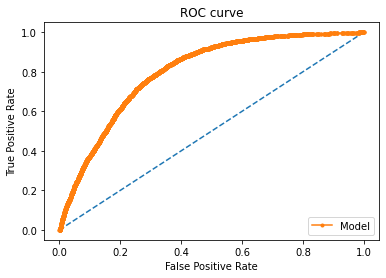

In [135]:
plot_ROC(regLog_noserv, X_test_noserv, y_test_noserv, scaler_noserv)

## Bosques aleatorios

### Con todas las variables

In [136]:
X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(X_noprestacion_dum, y_noprestacion, test_size=0.33, random_state=42,
                                                               stratify=y_noprestacion)

In [138]:
# Escalador de datos
scaler = preprocessing.StandardScaler().fit(X_train_sp)
# Validacion cruzada
arb = RandomForestClassifier(random_state=42)
vc = cross_val_score(arb, scaler.transform(X_train_sp), y_train_sp, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Accuracy para Bosque Aleatorio con validación cruzada: {:1.4f} ".format(accuracy) )

Accuracy para Bosque Aleatorio con validación cruzada: 0.8264 


In [140]:
vc

array([0.82923497, 0.82906421, 0.82803962, 0.82462432, 0.82117848])

In [139]:
forest_sp, X_test_sp, y_test_sp, y_pred_forest_sp, scaler_sp = random_forest(X_noprestacion_dum, y_noprestacion)

Accuracy del test: 0.8317
La sensitividad(recall) del test es: 0.7737


In [40]:
plot_CM(y_test_sp, y_pred_forest_sp)

Predicted,No,Sí
True,,
No,3405,1095
Sí,961,3539


Model: ROC AUC = 0.913


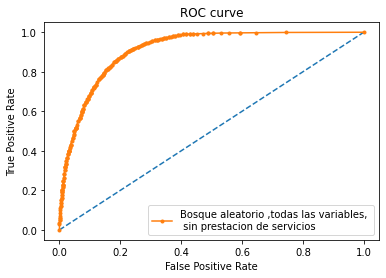

In [141]:
plot_ROC(forest_sp, X_test_sp, y_test_sp, scaler_sp, model_name='Bosque aleatorio ,todas las variables, \n sin prestacion de servicios')

### Con las 5 seleccionadas

In [154]:
cols = ['cantidad de palabras objeto a contratar',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Plazo en dias de Ejec del Contrato',
       'Cuantia Contrato',
       'mismo detalle objeto a contratar despues de firma_1']

In [155]:
X_sp_fselec = X_noprestacion_dum[cols]

In [156]:
X_train_sp_sel1, X_test_sp_sel1, y_train_sp_sel1, y_test_sp_sel1 = train_test_split(X_sp_fselec, y_noprestacion, test_size=0.33, random_state=42,
                                                               stratify=y_noprestacion)

In [157]:
X_train_sp_sel1.shape

(29279, 5)

In [158]:
# Escalador de datos
scaler_sp_sel1 = preprocessing.StandardScaler().fit(X_train_sp_sel1)
# Validacion cruzada
arb = RandomForestClassifier(random_state=42)
vc = cross_val_score(arb, scaler_sp_sel1.transform(X_train_sp_sel1), y_train_sp_sel1, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Con solo 5 variables")
print("Accuracy para Bosque Aleatorio con validación cruzada: {:1.4f} ".format(accuracy) )

Con solo 5 variables
Accuracy para Bosque Aleatorio con validación cruzada: 0.8022 


In [159]:
vc

array([0.80806011, 0.80122951, 0.80959699, 0.80122951, 0.79077711])

In [160]:
forest_sp_sel1, X_test_sp_sel1, y_test_sp_sel1, y_pred_forest_sp_sel1, scaler_sp_sel1 = random_forest(X_sp_fselec, y_noprestacion)

Accuracy del test: 0.8042
La sensitividad(recall) del test es: 0.7523


In [161]:
plot_CM(y_test_sp_sel1, y_pred_forest_sp_sel1)

Predicted,No,Sí
True,,
No,7026,1409
Sí,1158,3517


Model: ROC AUC = 0.887


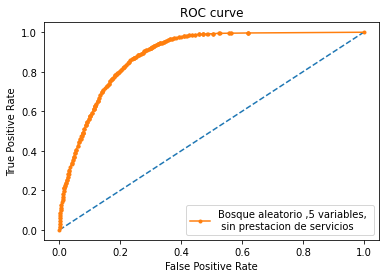

In [162]:
plot_ROC(forest_sp_sel1, X_test_sp_sel1, y_test_sp_sel1, scaler_sp_sel1, model_name='Bosque aleatorio ,5 variables, \n sin prestacion de servicios')

## Modelos con sólo prestación de servicios

In [173]:
X_soloprestacion = df_downsampled_MA[df_downsampled_MA["Tipo de Contrato"] == "Prestación de Servicios"]
y_soloprestacion = X_soloprestacion["Marc Adiciones"]

X_soloprestacion = X_soloprestacion.drop(columns = vars_a_excluir + ["Marc Adiciones","Adicion en Valor","Adicion en Tiempo",
                                                                 "Marc Sancion","Valor Total de Adiciones"])

vars_categoricas = ['Tipo de Proceso', 'Causal de Otras Formas de Contratacion Directa',
                    'Regimen de Contratacion', 'Tipo de Contrato','Nombre Grupo',"Dpto y Muni Contratista",
                    'EsPostConflicto', 'Def Origen Recur',"mismo detalle objeto a contratar despues de firma",
                    "Mes Firma Contrato","Dia del Mes Firma Contrato","Dia de la Semana Firma Contrato"]
X_soloprestacion_dum = pd.get_dummies(data = X_soloprestacion, columns = vars_categoricas)
X_soloprestacion_dum = X_soloprestacion_dum.drop(columns=['Ultima Actualizacion - Fecha Fin Ejec Contrato','Tiempo Adiciones (Dias)'])

In [177]:
print("Cantidad de datos sin prestacion de servicios: ",len(X_soloprestacion))
y_soloprestacion.value_counts()

Cantidad de datos sin prestacion de servicios:  260216


1    136374
0    123842
Name: Marc Adiciones, dtype: int64

**Nota:** es necesario remuestrear para ejecutar los modelos más rapidamente. Para los modelos utilizaremos 15000 muestras por clase de la variable dependiente `Marc Adiciones`.

In [179]:
X_soloprest_MA, y_soloprest_MA = small_balanced_sample(X_soloprestacion_dum,y_soloprestacion,15000)

## Regresión logística

### Con todas las variables

In [180]:
regLog_soloserv, X_test_soloserv, y_test_soloserv, y_pred_soloserv, scaler_soloserv = reg_log(X_soloprest_MA, y_soloprest_MA)

Accuracy para Regresión Logística con validación cruzada: 0.6123 
El accuracy del test es: 0.6141
La sensitividad(recall) del test es: 0.6593


In [181]:
plot_CM(y_test_soloserv, y_pred_soloserv)

Predicted,No,Sí
True,,
No,2560,1940
Sí,1533,2967


Model: ROC AUC = 0.662


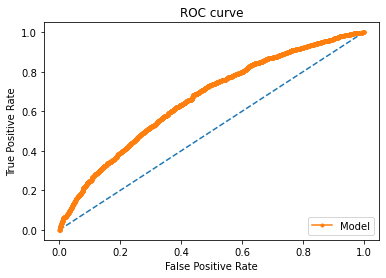

In [182]:
plot_ROC(regLog_soloserv, X_test_soloserv, y_test_soloserv, scaler_soloserv)

## Bosques aleatorios

### Con todas las variables

In [183]:
X_train_soloserv, X_test_soloserv, y_train_soloserv, y_test_soloserv = train_test_split(X_soloprest_MA, y_soloprest_MA, test_size=0.33, random_state=42,
                                                               stratify=y_soloprest_MA)

In [184]:
# Escalador de datos
scaler = preprocessing.StandardScaler().fit(X_train_soloserv)
# Validacion cruzada
arb = RandomForestClassifier(random_state=42)
vc = cross_val_score(arb, scaler.transform(X_train_soloserv), y_train_soloserv, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Solo prestacion de servicios")
print("Accuracy para Bosque Aleatorio con validación cruzada: {:1.4f} ".format(accuracy) )

Solo prestacion de servicios
Accuracy para Bosque Aleatorio con validación cruzada: 0.7609 


In [185]:
vc

array([0.76094527, 0.76517413, 0.76293532, 0.75124378, 0.7641791 ])

In [186]:
forest_soloserv, X_test_soloserv, y_test_soloserv, y_pred_forest_soloserv, scaler_soloserv = random_forest(X_noprestacion_dum, y_noprestacion)

Accuracy del test: 0.8317
La sensitividad(recall) del test es: 0.7737


In [188]:
plot_CM(y_test_soloserv, y_pred_forest_soloserv)

Predicted,No,Sí
True,,
No,7286,1149
Sí,1058,3617


Model: ROC AUC = 0.913


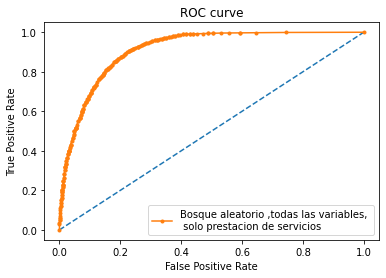

In [189]:
plot_ROC(forest_soloserv, X_test_soloserv, y_test_soloserv, scaler_soloserv, model_name='Bosque aleatorio ,todas las variables, \n solo prestacion de servicios')

### Con las 5 seleccionadas

In [190]:
cols = ['cantidad de palabras objeto a contratar',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Plazo en dias de Ejec del Contrato',
       'Cuantia Contrato',
       'mismo detalle objeto a contratar despues de firma_1']

In [195]:
X_soloserv_fselec = X_soloprest_MA[cols]

In [198]:
X_train_soloserv_sel, X_test_soloserv_sel, y_train_soloserv_sel, y_test_soloserv_sel = train_test_split(X_soloserv_fselec, y_soloprest_MA,
                                                                                                        test_size=0.33, random_state=42,stratify=y_soloprest_MA)

In [199]:
X_train_soloserv_sel.shape

(20100, 5)

In [200]:
# Escalador de datos
scaler_soloserv_sel = preprocessing.StandardScaler().fit(X_train_soloserv_sel)
# Validacion cruzada
arb = RandomForestClassifier(random_state=42)
vc = cross_val_score(arb, scaler_soloserv_sel.transform(X_train_soloserv_sel), y_train_soloserv_sel, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Con solo 5 variables")
print("Accuracy para Bosque Aleatorio con validación cruzada: {:1.4f} ".format(accuracy) )

Con solo 5 variables
Accuracy para Bosque Aleatorio con validación cruzada: 0.7320 


In [201]:
vc

array([0.72761194, 0.72935323, 0.74228856, 0.71915423, 0.74154229])

In [202]:
forest_soloserv_sel, X_test_soloserv_sel, y_test_soloserv_sel, y_pred_forest_soloserv_sel, scaler_soloserv_sel = random_forest(X_soloserv_fselec, y_soloprest_MA)

Accuracy del test: 0.7384
La sensitividad(recall) del test es: 0.7382


In [203]:
plot_CM(y_test_soloserv_sel, y_pred_forest_soloserv_sel)

Predicted,No,Sí
True,,
No,3324,1176
Sí,1178,3322


Model: ROC AUC = 0.829


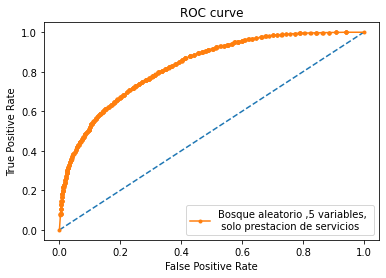

In [204]:
plot_ROC(forest_soloserv_sel, X_test_soloserv_sel, y_test_soloserv_sel, scaler_soloserv_sel, model_name='Bosque aleatorio ,5 variables, \n solo prestacion de servicios')

---

# 2. Modelos para output `Adicion en Valor`

## Bosque Aleatorio

### Con todas las variables

In [205]:
vars_categoricas

['Tipo de Proceso',
 'Causal de Otras Formas de Contratacion Directa',
 'Regimen de Contratacion',
 'Tipo de Contrato',
 'Nombre Grupo',
 'Dpto y Muni Contratista',
 'EsPostConflicto',
 'Def Origen Recur',
 'mismo detalle objeto a contratar despues de firma',
 'Mes Firma Contrato',
 'Dia del Mes Firma Contrato',
 'Dia de la Semana Firma Contrato']

In [224]:
#El termino "_AV" al final se refiere a Adiciones en Valor
df_downsampled_AV = balance(df, "Adicion en Valor")

X_down = pd.get_dummies(data = df_downsampled_AV, columns =  vars_categoricas+["Tipo de Contrato"])
# Quitamos las variables relacionadas con adiciones y sancion
X_down = X_down.drop(columns = vars_a_excluir + ['Marc Adiciones','Adicion en Valor','Adicion en Tiempo',
                                                'Valor Total de Adiciones','Marc Sancion','Valor Sancion'])

y2_down_AV = df_downsampled_AV["Adicion en Valor"]

In [225]:
X_down_dum = X_down.drop(columns = ["Tiempo Adiciones (Dias)",'Ultima Actualizacion - Fecha Fin Ejec Contrato'])
X_down_dum.shape

(283928, 221)

### Selección de variables con Random Forest

In [226]:
# Tarda un poco
X_fselec = feature_selection(X_down_dum, y2_down_AV)

Variables estadísticamente significativas: 
['cantidad de palabras objeto a contratar', 'cantidad de palabras objeto del contrato a la Firma', 'Fecha Firma Contrato - Fecha Cargue Secop', 'Fecha Ini Ejec - Fecha Firma Contrato', 'Plazo en dias de Ejec del Contrato', 'Cuantia Contrato', 'Tipo de Proceso_Régimen Especial', 'Causal de Otras Formas de Contratacion Directa_Ninguna', 'Causal de Otras Formas de Contratacion Directa_Prestación de Servicios Profesionales y de Apoyo a la Gestión (Literal H)', 'Regimen de Contratacion_Estatuto General de Contratación', 'Tipo de Contrato_Prestación de Servicios', 'Nombre Grupo_[F] Servicios', 'Dpto y Muni Contratista_Bogotá D.C.', 'Dpto y Muni Contratista_Cundinamarca', 'Def Origen Recur_0', 'Def Origen Recur_1', 'mismo detalle objeto a contratar despues de firma_0', 'mismo detalle objeto a contratar despues de firma_1', 'Mes Firma Contrato_Abril', 'Mes Firma Contrato_Agosto', 'Mes Firma Contrato_Diciembre', 'Mes Firma Contrato_Enero', 'Mes Firma 

In [227]:
len(X_fselec.columns)

40

## Modelos con cantidad reducida de filas

In [228]:
print("Datos iniciales por clase")
print(y2_down_AV.value_counts())
N = 15000 # 150000 por clase
X_AV, y_AV = small_balanced_sample(X_down_dum,y2_down_AV,N)
print("Nueva cantidad de datos por clase:")
print(y_AV.value_counts())
print("Dimension de matriz X: ",X_AV.shape)

Datos iniciales por clase
1    141964
0    141964
Name: Adicion en Valor, dtype: int64
Nueva cantidad de datos por clase:
1    15000
0    15000
Name: Adicion en Valor, dtype: int64
Dimension de matriz X:  (30000, 221)


### Con todas las variables

In [229]:
X_train_AV, X_test_AV, y_train_AV, y_test_AV = train_test_split(X_AV, y_AV, test_size=0.33, random_state=42)

In [230]:
# Escalador de datos
scaler = preprocessing.StandardScaler().fit(X_train_AV)
# Validacion cruzada
reglog = LogisticRegression(max_iter = 500)
vc = cross_val_score(reglog, scaler.transform(X_train_AV), y_train_AV, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Accuracy para Regresión Logística con validación cruzada: {:1.4f} ".format(accuracy) )

Accuracy para Regresión Logística con validación cruzada: 0.6404 


In [231]:
reglog = LogisticRegression(max_iter=500)
reglog.fit(scaler.transform(X_train_AV),y_train_AV)

LogisticRegression(max_iter=500)

In [232]:
y_pred = reglog.predict(scaler.transform(X_test_AV))
print("El accuracy del test es: {:1.4f}".format( accuracy_score(y_test_AV, y_pred) ))
print("La sensitividad(recall) del test es: {:1.4f}".format( recall_score(y_test_AV, y_pred) ))

El accuracy del test es: 0.6389
La sensitividad(recall) del test es: 0.6931


In [233]:
plot_CM(y_test_AV, y_pred,norm='true')

Predicted,No,Sí
True,,
No,0.584730,0.415270
Sí,0.306931,0.693069


Model: ROC AUC = 0.687


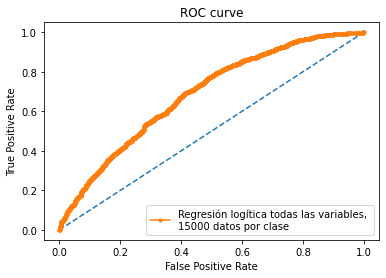

In [234]:
plot_ROC(reglog, X_test_AV, y_test_AV, scaler, model_name='Regresión logítica todas las variables, \n'+str(N)+" datos por clase")

### Con primera selección de variables

In [237]:
# Primero reducimos la cantidad de filas 
N = 15000 # 150000 por clase
X_fselec_AV, y_fselec_AV = small_balanced_sample(X_fselec,y2_down_AV,N)

In [239]:
# Escalador de datos
scaler2 = preprocessing.StandardScaler().fit(X_fselec_AV)
# Validacion cruzada
reglog2 = LogisticRegression(max_iter = 500)
vc = cross_val_score(reglog2, scaler2.transform(X_fselec_AV), y_fselec_AV, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Accuracy para Regresión Logística con validación cruzada, 1era SELECCION DE VARIABLES: {:1.4f} ".format(accuracy) )

Accuracy para Regresión Logística con validación cruzada, 1era SELECCION DE VARIABLES: 0.5008 


In [240]:
regLog2, X_test2_AV, y_test2_AV, y_pred2_AV, scaler2_AV = reg_log(X_fselec_AV, y_fselec_AV)

Accuracy para Regresión Logística con validación cruzada: 0.5079 
El accuracy del test es: 0.4987
La sensitividad(recall) del test es: 0.5200


In [241]:
plot_CM(y_test2_AV, y_pred2_AV,norm='true')

Predicted,No,Sí
True,,
No,0.477333,0.522667
Sí,0.480000,0.520000


Model: ROC AUC = 0.502


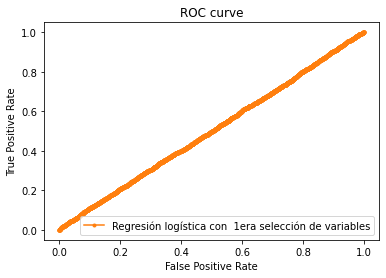

In [242]:
plot_ROC(regLog2, X_test2_AV, y_test2_AV, scaler2_AV, model_name='Regresión logística con  1era selección de variables')

## Bosques Aleatorios

### Con todas las variables

In [243]:
print(X_train_AV.shape, y_train_AV.shape)

(20100, 221) (20100,)


In [244]:
np.array(X_train_AV.columns)

array(['cantidad de palabras objeto a contratar',
       'cantidad de palabras objeto del contrato a la Firma',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Fecha Ini Ejec - Fecha Firma Contrato',
       'Plazo en dias de Ejec del Contrato', 'Cuantia Contrato',
       'Tipo de Proceso_Asociación Público Privada',
       'Tipo de Proceso_Concurso de Méritos Abierto',
       'Tipo de Proceso_Concurso de Méritos con Lista Corta',
       'Tipo de Proceso_Contratación Directa (Ley 1150 de 2007)',
       'Tipo de Proceso_Contratación Mínima Cuantía',
       'Tipo de Proceso_Contratos y convenios con más de dos partes',
       'Tipo de Proceso_Licitación Pública',
       'Tipo de Proceso_Licitación obra pública',
       'Tipo de Proceso_Régimen Especial',
       'Tipo de Proceso_Selección Abreviada de Menor Cuantía (Ley 1150 de 2007)',
       'Tipo de Proceso_Selección Abreviada del literal h del numeral 2 del artículo 2 de la Ley 1150 de 2007',
       'Tipo de Proceso_Selecció

In [245]:
# Escalador de datos
scaler = preprocessing.StandardScaler().fit(X_train_AV)
# Validacion cruzada
arb = RandomForestClassifier(random_state=42)
vc = cross_val_score(arb, scaler.transform(X_train_AV), y_train_AV, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Accuracy para Bosque Aleatorio con validación cruzada: {:1.4f} ".format(accuracy) )

Accuracy para Bosque Aleatorio con validación cruzada: 0.7708 


In [246]:
vc

array([0.77164179, 0.76616915, 0.7778607 , 0.76691542, 0.77164179])

In [247]:
X_AV.shape[1]

221

In [248]:
forest, X_test, y_test, y_pred_forest, scaler = random_forest(X_AV, y_AV)

Accuracy del test: 0.7768
La sensitividad(recall) del test es: 0.7818


In [249]:
plot_CM(y_test, y_pred_forest)

Predicted,No,Sí
True,,
No,3473,1027
Sí,982,3518


Model: ROC AUC = 0.868


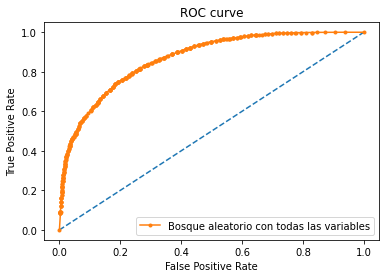

In [250]:
plot_ROC(forest, X_test, y_test, scaler, model_name='Bosque aleatorio con todas las variables')

### Con primera selección de variables

In [252]:
# Con X_fselec_AV, y_fselec_AV
N = 15000 # datos por clase
X_fselec_AV, y_fselec_AV = small_balanced_sample(X_fselec,y2_down_AV,N)
# Resultados
forest_s1, X_test_s1, y_test_s1, y_pred_forest_s1, scaler_s1 = random_forest(X_fselec_AV, y_fselec_AV)

Accuracy del test: 0.5018
La sensitividad(recall) del test es: 0.4887


In [253]:
print(X_fselec_AV.shape)
print(np.array(X_fselec_AV.columns))

(30000, 40)
['cantidad de palabras objeto a contratar'
 'cantidad de palabras objeto del contrato a la Firma'
 'Fecha Firma Contrato - Fecha Cargue Secop'
 'Fecha Ini Ejec - Fecha Firma Contrato'
 'Plazo en dias de Ejec del Contrato' 'Cuantia Contrato'
 'Tipo de Proceso_Régimen Especial'
 'Causal de Otras Formas de Contratacion Directa_Ninguna'
 'Causal de Otras Formas de Contratacion Directa_Prestación de Servicios Profesionales y de Apoyo a la Gestión (Literal H)'
 'Regimen de Contratacion_Estatuto General de Contratación'
 'Tipo de Contrato_Prestación de Servicios' 'Nombre Grupo_[F] Servicios'
 'Dpto y Muni Contratista_Bogotá D.C.'
 'Dpto y Muni Contratista_Cundinamarca' 'Def Origen Recur_0'
 'Def Origen Recur_1'
 'mismo detalle objeto a contratar despues de firma_0'
 'mismo detalle objeto a contratar despues de firma_1'
 'Mes Firma Contrato_Abril' 'Mes Firma Contrato_Agosto'
 'Mes Firma Contrato_Diciembre' 'Mes Firma Contrato_Enero'
 'Mes Firma Contrato_Febrero' 'Mes Firma Contrato

In [254]:
plot_CM(y_test_s1, y_pred_forest_s1)

Predicted,No,Sí
True,,
No,2317,2183
Sí,2301,2199


Model: ROC AUC = 0.503


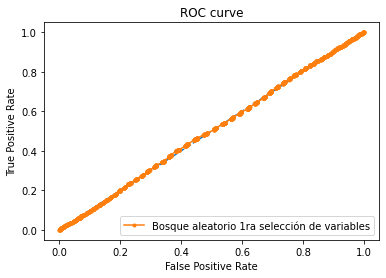

In [255]:
plot_ROC(forest_s1, X_test_s1, y_test_s1, scaler_s1, model_name='Bosque aleatorio 1ra selección de variables')

### Con selección específica de 5 variables

In [257]:
cols = ['cantidad de palabras objeto a contratar',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Plazo en dias de Ejec del Contrato',
       'Cuantia Contrato',
       'mismo detalle objeto a contratar despues de firma_1']

In [259]:
X_fselec_3_AV = X_down_dum[cols]

In [52]:
X_fselec_3_AV.shape

(303916, 5)

In [261]:
X_s3_AV, y_s3_AV = small_balanced_sample(X_fselec_3_AV,y2_down_AV,15000)

In [262]:
X_train_s3_AV, X_test_s3_AV, y_train_s3_AV, y_test_s3_AV = train_test_split(X_s3_AV, y_s3_AV,
                                                                            test_size=0.33, random_state=42)
# Escalador de datos
scaler_s3 = preprocessing.StandardScaler().fit(X_train_s3_AV)
# Validacion cruzada
arb = RandomForestClassifier(random_state=42)
vc = cross_val_score(arb, scaler_s3.transform(X_train_s3_AV), y_train_s3_AV, cv = 5, scoring = "accuracy")
accuracy = vc.mean()
print("Accuracy para Bosque Aleatorio con validación cruzada: {:1.4f} ".format(accuracy) )

Accuracy para Bosque Aleatorio con validación cruzada: 0.7467 


In [263]:
vc

array([0.73557214, 0.74651741, 0.75820896, 0.74975124, 0.74328358])

In [264]:
X_train_s3_AV.shape

(20100, 5)

In [265]:
# Con X_fselec_AV, y_fselec_AV
N = 15000 # datos por clase
X_fselec_3_AV, y_fselec_3_AV = small_balanced_sample(X_fselec_3_AV,y2_down_AV,N)
# Resultados
forest_s3, X_test_s3, y_test_s3, y_pred_forest_s3, scaler_s3 = random_forest(X_fselec_3_AV, y_fselec_3_AV)

Accuracy del test: 0.7450
La sensitividad(recall) del test es: 0.7582


In [266]:
plot_CM(y_test_s3, y_pred_forest_s3)

Predicted,No,Sí
True,,
No,3293,1207
Sí,1088,3412


Model: ROC AUC = 0.837


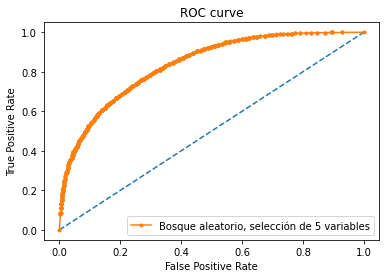

In [267]:
plot_ROC(forest_s3, X_test_s3, y_test_s3, scaler_s3, model_name='Bosque aleatorio, selección de 5 variables')

## Modelos sin prestaciones de servicios

In [279]:
df_downsampled_AV["Tipo de Contrato"].value_counts()

Prestación de Servicios    245833
Suministro                  14382
Otro Tipo de Contrato        8665
Compraventa                  5228
Obra                         4686
Arrendamiento                2668
Interventoría                1080
Consultoría                   687
Comodato                      559
Acuerdo Marco                  62
Concesión                      32
Fiducia                        22
Crédito                        17
No definido                     5
Agregación de Demanda           2
Name: Tipo de Contrato, dtype: int64

In [280]:
df_downsampled_AV.columns

Index(['UID', 'Orden Entidad', 'Nombre de la Entidad', 'Código de la Entidad',
       'Tipo de Proceso', 'Estado del Proceso',
       'Causal de Otras Formas de Contratacion Directa',
       'Regimen de Contratacion', 'Objeto a Contratar', 'Tipo de Contrato',
       'cantidad de palabras objeto a contratar', 'Nombre Grupo',
       'Nombre Familia', 'Nombre Clase', 'EsPostConflicto', 'Def Origen Recur',
       'Num Origenes Recur', 'Descrip Origenes Recur', 'ID Ajudicacion',
       'Tipo Identifi del Contratista',
       'cantidad de palabras objeto del contrato a la Firma',
       'mismo detalle objeto a contratar despues de firma',
       'Identificacion del Contratista', 'Nom Raz Social Contratista',
       'Dpto y Muni Contratista', 'Fecha de Cargue en el SECOP',
       'Fecha de Firma del Contrato', 'Fecha Ini Ejec Contrato',
       'Fecha Firma Contrato - Fecha Cargue Secop',
       'Fecha Ini Ejec - Fecha Firma Contrato', 'Mes Firma Contrato',
       'Dia del Mes Firma Contrato',

In [281]:
X_noprestacion = df_downsampled_AV[df_downsampled_AV["Tipo de Contrato"] != "Prestación de Servicios"]
y_noprestacion = X_noprestacion["Marc Adiciones"]

X_noprestacion = X_noprestacion.drop(columns = vars_a_excluir + ["Marc Adiciones","Adicion en Valor","Adicion en Tiempo",
                                                                 "Marc Sancion","Valor Total de Adiciones"])

vars_categoricas = ['Tipo de Proceso', 'Causal de Otras Formas de Contratacion Directa',
                    'Regimen de Contratacion', 'Tipo de Contrato','Nombre Grupo',"Dpto y Muni Contratista",
                    'EsPostConflicto', 'Def Origen Recur',"mismo detalle objeto a contratar despues de firma",
                    "Mes Firma Contrato","Dia del Mes Firma Contrato","Dia de la Semana Firma Contrato"]
X_noprestacion_dum = pd.get_dummies(data = X_noprestacion, columns = vars_categoricas)
X_noprestacion_dum = X_noprestacion_dum.drop(columns=['Ultima Actualizacion - Fecha Fin Ejec Contrato','Tiempo Adiciones (Dias)'])

In [283]:
print("Cantidad de datos sin prestacion de servicios: ",len(X_noprestacion))
y_noprestacion.value_counts()

Cantidad de datos sin prestacion de servicios:  38095


0    25780
1    12315
Name: Marc Adiciones, dtype: int64